In [ ]:
# %%capture
# !gdown 1CMcTsxSzz6vzvrq_OIwOJFtowI3KHPOa
# !gdown 1JnaVPaqDA60zpT7gkq6VtIPf8nlBGi87
# !unzip Timeline20250531.zip

In [1]:
import os
len(os.listdir('Timeline20250531/cliplets/'))

13046

In [2]:
import pandas as pd
filenames = os.listdir('Timeline20250531/cliplets/')
data = pd.DataFrame({'filename': filenames})
data['letter'] = data.filename.apply(lambda x: x.split('_')[0])
data['TM'] = data.filename.apply(lambda x: int(x.split('_')[1]))
data['number'] = data.filename.apply(lambda x: x.split('_')[2].split('.')[0])
print(data.shape[0])
data.sample(5)
ground_truth_labels = data['letter'].values

13046


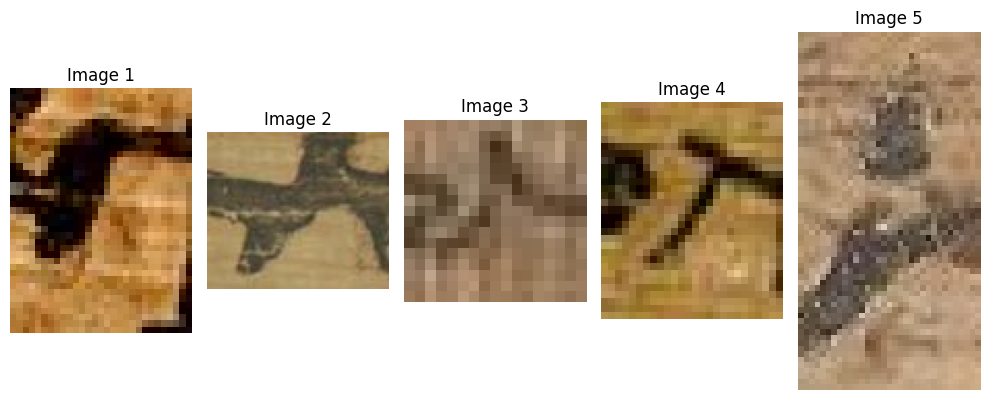

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_folder = 'Timeline20250531/cliplets/'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display a few images
num_images_to_display = min(5, len(image_files))

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    img_path = image_files[i]
    img = mpimg.imread(img_path)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

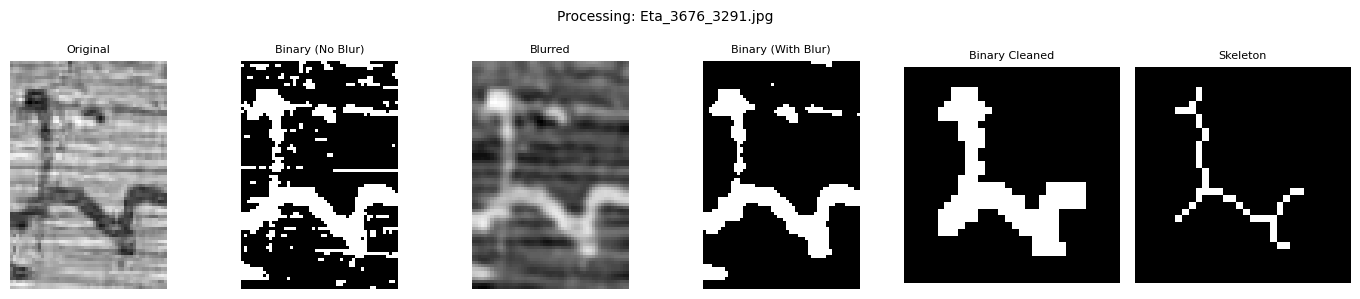

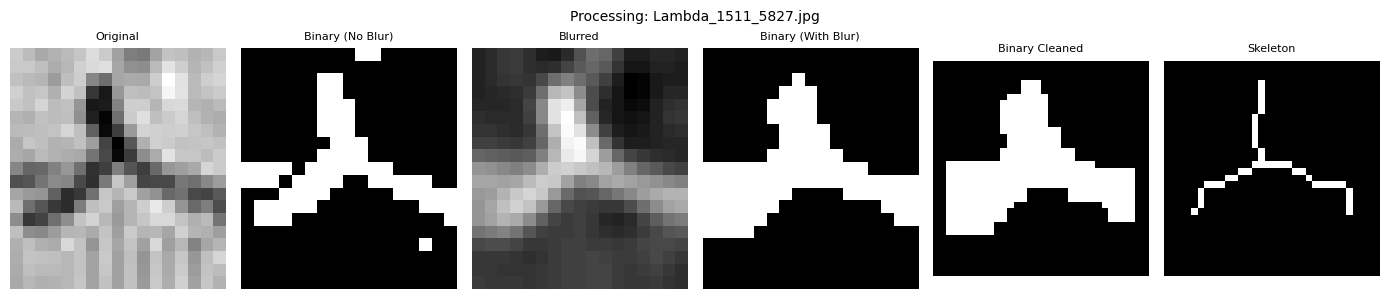

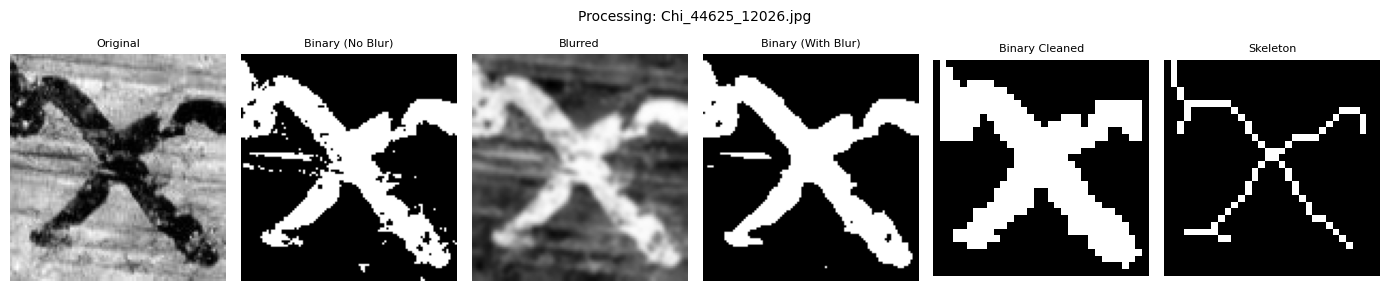

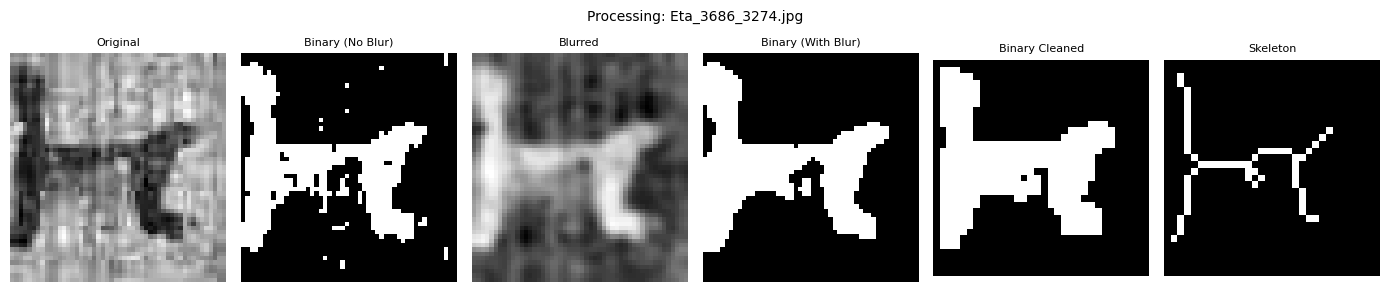

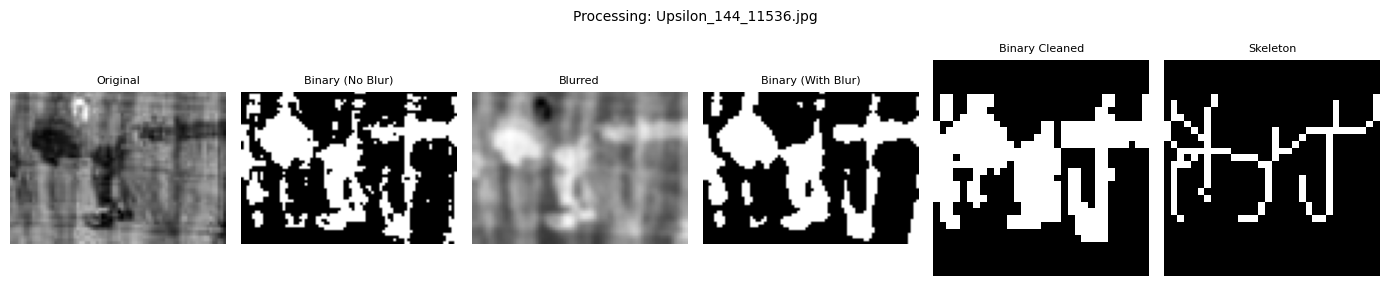

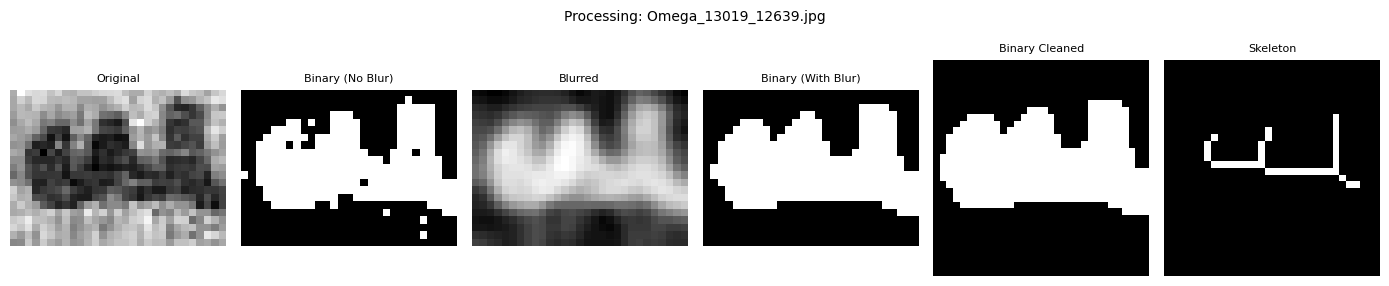

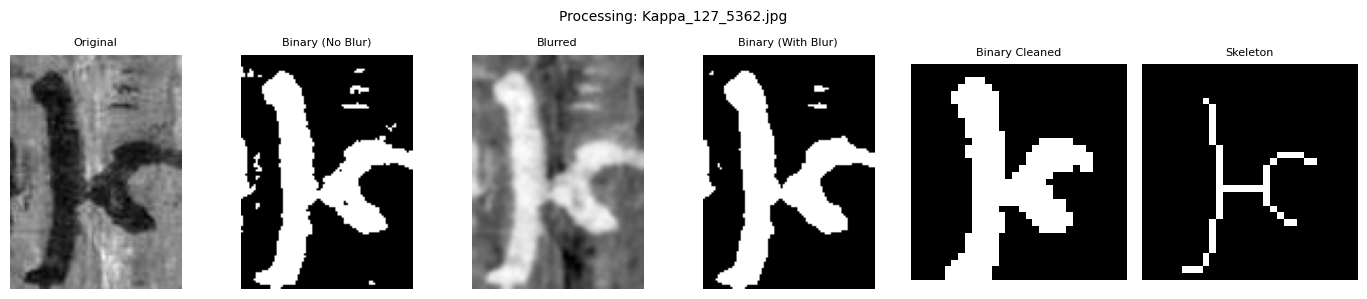

In [77]:

from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from skimage.morphology import remove_small_objects
from skimage.measure import label
import warnings
import cv2

warnings.filterwarnings("ignore")


def resize_with_aspect_ratio(image, size=(32, 32), padding_value=0):
    h, w = image.shape[:2]
    target_w, target_h = size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    result = np.full((target_h, target_w), padding_value, dtype=image.dtype)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return result

def preprocess_image_with_debug(image_path, size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)
    
    # Invert image
    img_inverted = 255 - img_np

    # Without blur
    _, img_bin_noblur = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # With blur
    img_blur = cv2.GaussianBlur(img_inverted, (5, 5), 0)
    _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = resize_with_aspect_ratio(img_bin, size, padding_value=0)
    
    # Remove small objects
    img_bin_bool = img_resized.astype(bool)
    img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)
    img_bin_cleaned = (img_cleaned > 0).astype(np.uint8) * 255
    
    img_sk = skeletonize(img_bin_cleaned)
    img_normalized = img_sk.astype(np.float32) / 255.0
    
    return {
        'original': img_np,
        'bin_no_blur': img_bin_noblur,
        'blurred': img_blur,
        'binary': img_bin,
        'binary_cleaned': img_bin_cleaned,
        'skeleton': img_sk,
        'final': img_normalized
    }


# Plot multiple images in a cleaner way
for img_path in image_files[100:107]:
    stages = preprocess_image_with_debug(img_path)
    if stages is None:
        continue
    fig, axs = plt.subplots(1, 6, figsize=(14, 3))
    fig.suptitle(f'Processing: {img_path.split("/")[-1]}', fontsize=10)

    axs[0].imshow(stages['original'], cmap='gray')
    axs[0].set_title('Original', fontsize=8)

    axs[1].imshow(stages['bin_no_blur'], cmap='gray')
    axs[1].set_title('Binary (No Blur)', fontsize=8)

    axs[2].imshow(stages['blurred'], cmap='gray')
    axs[2].set_title('Blurred', fontsize=8)

    axs[3].imshow(stages['binary'], cmap='gray')
    axs[3].set_title('Binary (With Blur)', fontsize=8)

    axs[4].imshow((stages['binary_cleaned'] > 0).astype(np.uint8) * 255, cmap='gray')
    axs[4].set_title('Binary Cleaned', fontsize=8)

    axs[5].imshow(stages['skeleton'], cmap='gray')
    axs[5].set_title('Skeleton', fontsize=8)

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [78]:
def preprocess_image(image_path, size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)
    # Invert image
    img_inverted = 255 - img_np

    # With blur
    img_blur = cv2.GaussianBlur(img_inverted, (5, 5), 0)
    _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = resize_with_aspect_ratio(img_bin, size, padding_value=0)
    
    # Remove small objects
    img_bin_bool = img_resized.astype(bool)
    img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)
    img_bin_cleaned = (img_cleaned > 0).astype(np.uint8) * 255
    img_normalized = img_bin_cleaned.astype(np.float32) / 255.0
    return img_normalized.flatten()

image_data = []
labels = []
for i,img_path in enumerate(image_files):
    try:
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            image_data.append(processed_img)
            labels.append(ground_truth_labels[i])
    except Exception as e:
        print(f"Error processing image {image_data}: {e}")

image_data = np.array(image_data)
labels = np.array(labels)
print(f"Processed {len(image_data)} images with labels.")

Processed 13046 images with labels.


In [79]:
known_data = image_data[labels != 'Unknown']
known_labels = labels[labels != 'Unknown']
print(known_data.shape, known_labels.shape)

(13014, 1024) (13014,)


Loaded 13014 images with shape (1024,)
Applying PCA to reduce to 50 dimensions...
Performing Spectral Clustering on PCA features...


NMI Score: 0.4321


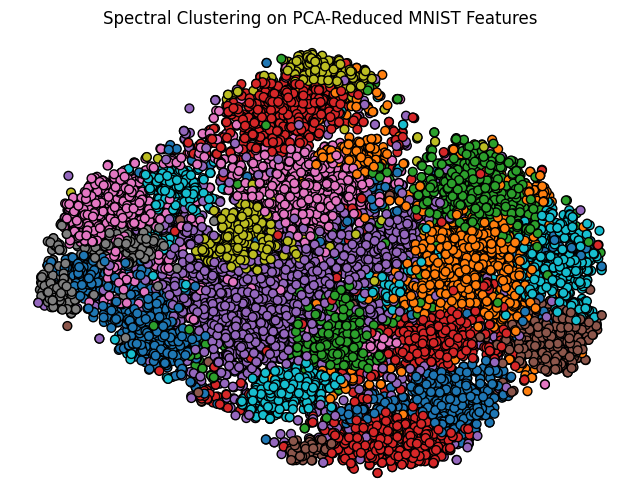

In [80]:
# 2. PCA Feature Extraction
def extract_pca_features(X, n_components=50):
    print(f"Applying PCA to reduce to {n_components} dimensions...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

# 3. Clustering and Visualization
def cluster_and_visualize(X_pca, y):
    print("Performing Spectral Clustering on PCA features...")
    spectral = SpectralClustering(n_clusters=24, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(X_pca)

    nmi = normalized_mutual_info_score(y, cluster_labels)
    print(f"NMI Score: {nmi:.4f}")

    # t-SNE Visualization
    vis = TSNE(n_components=2, random_state=42).fit_transform(X_pca)
    plt.figure(figsize=(8, 6))
    plt.scatter(vis[:, 0], vis[:, 1], c=cluster_labels, cmap='tab10', s=40, edgecolor='k')
    plt.title("Spectral Clustering on PCA-Reduced MNIST Features")
    plt.axis('off')
    plt.show()
    return cluster_labels

X, y = known_data, np.array(known_labels)
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
X_pca = extract_pca_features(X, n_components=50)
cluster_labels = cluster_and_visualize(X_pca, y)

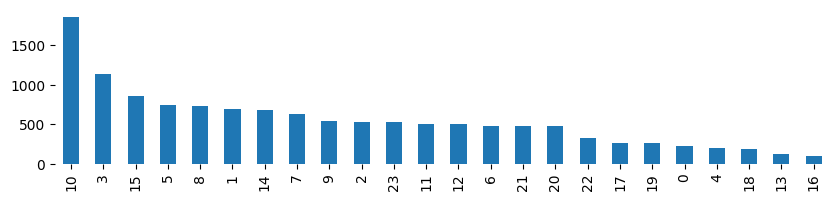

In [81]:
import seaborn as sns

pd.Series(cluster_labels).value_counts().plot.bar(figsize=(10,2));
sns.despine(left=True, bottom=True)

Cluster 0 (227 images):


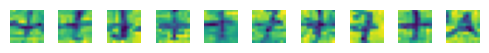

Cluster 1 (688 images):


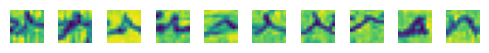

Cluster 2 (531 images):


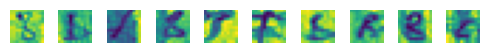

Cluster 3 (1141 images):


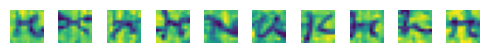

Cluster 4 (200 images):


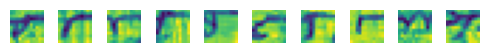

Cluster 5 (737 images):


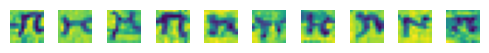

Cluster 6 (481 images):


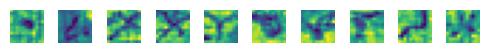

Cluster 7 (622 images):


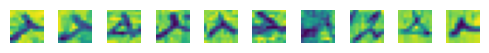

Cluster 8 (733 images):


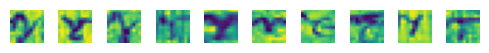

Cluster 9 (533 images):


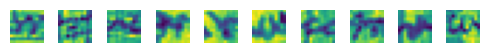

Cluster 10 (1859 images):


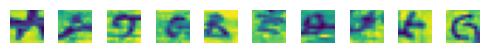

Cluster 11 (502 images):


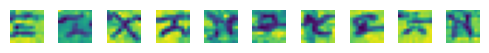

Cluster 12 (498 images):


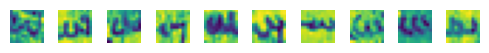

Cluster 13 (121 images):


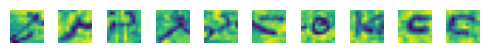

Cluster 14 (674 images):


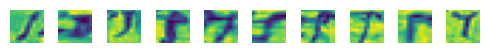

Cluster 15 (855 images):


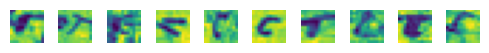

Cluster 16 (95 images):


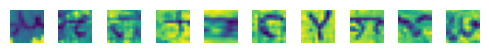

Cluster 17 (264 images):


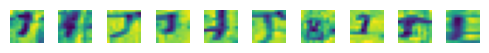

Cluster 18 (184 images):


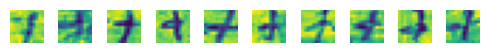

Cluster 19 (263 images):


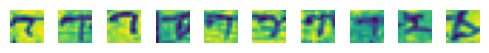

Cluster 20 (479 images):


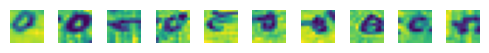

Cluster 21 (480 images):


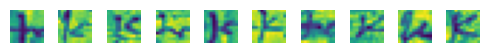

Cluster 22 (318 images):


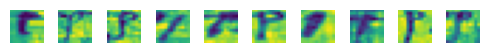

Cluster 23 (529 images):


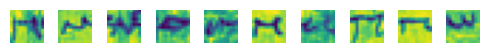

In [82]:
for cluster_id in range(24):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    num_images_in_cluster = len(cluster_indices)
    print(f"Cluster {cluster_id} ({num_images_in_cluster} images):")

    images_to_display = cluster_indices[:min(10, num_images_in_cluster)]

    if images_to_display.size > 0:
        plt.figure(figsize=(5, 10))
        for i, img_index in enumerate(images_to_display):
            img_path = image_files[img_index]
            # img = mpimg.imread(img_path)
            img = Image.open(img_path).convert('L').resize((12,12))
            plt.subplot(1, len(images_to_display), i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No images in this cluster to display.")

In [83]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

ground_truth_labels = data['letter'].values
nmi = normalized_mutual_info_score(known_labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")
ari = adjusted_rand_score(known_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

Normalized Mutual Information (NMI): 0.43211786733514496
Adjusted Rand Index (ARI): 0.2237703347472217


In [84]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
# Compute the average silhouette score
average_silhouette = silhouette_score(X_pca, cluster_labels)
print(f"Average Silhouette Score (Micro): {average_silhouette}")

Average Silhouette Score (Micro): 0.017373599112033844


In [85]:
cluster_silhouette_scores = []
for i in range(24):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 1: # Silhouette score is only defined for clusters with more than one point
        cluster_silhouette_scores.append(np.mean(sample_silhouette_values[cluster_indices]).item())
macro_silhouette = np.mean(cluster_silhouette_scores) if cluster_silhouette_scores else 0
print(f"Macro Silhouette Score (Average of Cluster Averages): {macro_silhouette}")
dict(zip(range(24), cluster_silhouette_scores))

Macro Silhouette Score (Average of Cluster Averages): 0.04862007381476966


{0: 0.1554209440946579,
 1: 0.026378488168120384,
 2: 0.020519854500889778,
 3: -0.026416324079036713,
 4: 0.110860675573349,
 5: 0.02382766455411911,
 6: 0.015519356355071068,
 7: 0.00881106872111559,
 8: -0.00033365070703439415,
 9: 0.015650181099772453,
 10: -0.06781445443630219,
 11: -0.003262616228312254,
 12: 0.09814383089542389,
 13: 0.09021445363759995,
 14: 0.007975582964718342,
 15: -0.023819388821721077,
 16: 0.1518164724111557,
 17: 0.09399331361055374,
 18: 0.0562434084713459,
 19: 0.10223670303821564,
 20: 0.07412896305322647,
 21: 0.04053856432437897,
 22: 0.10052916407585144,
 23: 0.09571951627731323}

In [86]:
# Calculate purity for each cluster
cluster_purity = {}
cluster_most_represented_letter = {}

for cluster_id in range(24):
    # Get indices of images belonging to the current cluster
    indices_in_cluster = np.where(cluster_labels == cluster_id)[0]

    if len(indices_in_cluster) > 0:
        # Get the ground truth letters for images in this cluster
        letters_in_cluster = ground_truth_labels[indices_in_cluster]

        # Count the occurrences of each letter in the cluster
        letter_counts = pd.Series(letters_in_cluster).value_counts()

        # The most frequent letter is the majority class
        most_frequent_letter = letter_counts.index[0]
        most_frequent_count = letter_counts.iloc[0]

        # Purity for the cluster is the fraction of the most frequent class
        purity = most_frequent_count / len(indices_in_cluster)

        cluster_purity[cluster_id] = purity
        cluster_most_represented_letter[cluster_id] = most_frequent_letter

# Create a DataFrame to display the results
purity_df = pd.DataFrame({
    'Cluster': list(cluster_purity.keys()),
    'Purity': list(cluster_purity.values()), # Added parentheses here
    'Most Represented Letter': list(cluster_most_represented_letter.values()) # Added parentheses here
})

# Sort the DataFrame by purity in descending order
purity_df_ranked = purity_df.sort_values(by='Purity', ascending=False)

print("\nCluster Purity and Most Represented Letter (Ranked by Purity):")
purity_df_ranked


Cluster Purity and Most Represented Letter (Ranked by Purity):


,Cluster,Purity,Most Represented Letter
16,16,0.105263,Kappa
17,17,0.098485,Iota
20,20,0.096033,Omicron
13,13,0.090909,Sigma
0,0,0.083700,Mu
19,19,0.083650,Tau
18,18,0.081522,Sigma
22,22,0.078616,Lambda
12,12,0.078313,Omega
4,4,0.075000,Alpha


In [88]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)

    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

Per-letter Purity Scores (sorted):
Letter 'Theta': 0.717
Letter 'Beta': 0.676
Letter 'Omega': 0.667
Letter 'Pi': 0.648
Letter 'Zeta': 0.618
Letter 'Epsilon': 0.610
Letter 'Upsilon': 0.571
Letter 'Nu': 0.493
Letter 'Sigma': 0.474
Letter 'Delta': 0.453
Letter 'Chi': 0.447
Letter 'Mu': 0.444
Letter 'Psi': 0.442
Letter 'Kappa': 0.440
Letter 'Iota': 0.438
Letter 'Omicron': 0.437
Letter 'Eta': 0.435
Letter 'Xi': 0.430
Letter 'Gamma': 0.421
Letter 'Phi': 0.408
Letter 'Rho': 0.375
Letter 'Tau': 0.371
Letter 'Lambda': 0.365
Letter 'Alpha': 0.341


In [61]:
from scipy.signal import convolve2d
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from skimage.util import view_as_windows
from scipy.signal import convolve2d
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore")


# 7. Clustering and Evaluation
def cluster_and_visualize(features, labels):
    # Normalize features (important for spectral clustering)
    features_norm = normalize(features)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=24, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_norm)

    # Evaluate clustering quality
    nmi = normalized_mutual_info_score(labels, cluster_labels)
    print(f"Spectral Clustering NMI Score: {nmi:.4f}")

    # # Visualize with t-SNE
    # vis = TSNE(n_components=2, random_state=42).fit_transform(features_norm)
    # plt.figure(figsize=(8, 6))
    # plt.scatter(vis[:, 0], vis[:, 1], c=cluster_labels, cmap='tab10', s=40, edgecolor='k')
    # plt.title("Spectral Clustering on PCANet Features")
    # plt.axis('off')
    # plt.show()
    return cluster_labels

print("Running Spectral Clustering...")
cluster_labels = cluster_and_visualize(features, known_labels)

Running Spectral Clustering...
Spectral Clustering NMI Score: 0.4122


In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)
    # cm = cm.T
    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

Per-letter Purity Scores (sorted):
Letter 'Theta': 0.738
Letter 'Omega': 0.697
Letter 'Pi': 0.671
Letter 'Phi': 0.669
Letter 'Psi': 0.663
Letter 'Beta': 0.640
Letter 'Delta': 0.618
Letter 'Rho': 0.599
Letter 'Epsilon': 0.597
Letter 'Chi': 0.593
Letter 'Iota': 0.557
Letter 'Upsilon': 0.544
Letter 'Gamma': 0.495
Letter 'Xi': 0.489
Letter 'Zeta': 0.473
Letter 'Mu': 0.462
Letter 'Nu': 0.460
Letter 'Omicron': 0.440
Letter 'Sigma': 0.410
Letter 'Lambda': 0.408
Letter 'Kappa': 0.373
Letter 'Alpha': 0.371
Letter 'Tau': 0.337
Letter 'Eta': 0.321
